## Theoretical Description of the Model

This Python code implements a **simple climate model** composed of two coupled ordinary differential equations (ODEs):

1. An **energy-balance equation** for the global-mean temperature anomaly \(T(t)\) (in °C above preindustrial).
2. A **one-box carbon cycle** that tracks atmospheric $CO_2$ (in ppm).

---

### 1. Temperature Equation

We assume the global-mean temperature anomaly \(T\) evolves according to:

$$
C \frac{dT}{dt} \;=\; F_{\mathrm{in}}(t) \;-\; \lambda_{\mathrm{cl}} \, T,
$$

where:

- $C$ is an effective **heat capacity** (units chosen so that $C \, dT/dt$ has dimensions of W m $^{-2}$).
- $\lambda_{\mathrm{cl}}$ (W m $^{-2}$ K $^{-1}$) is a **climate feedback parameter** (the planet radiates more as it warms).
- $F_{\mathrm{in}}(t)$ is the **anthropic radiative forcing** (W m $^{-2}$) applied to Earth.

In this code, we include only the **$CO_2$-induced forcing**. Using an IPCC-recommended approximation,

$$
F_{\mathrm{CO}_2}(t) \;=\; 5.35 \;\ln\!\Bigl(\frac{C_{\mathrm{atm}}(t)}{C_{\mathrm{atm},0}}\Bigr),
$$

where $C_{\mathrm{atm}}(t)$ is the atmospheric $CO_2$ (ppm) at time $t$, and $C_{\mathrm{atm},0} = 280$ ppm is the preindustrial reference. Therefore,

$$
F_{\mathrm{in}}(t) \;=\; F_0 \;+\; 5.35 \;\ln\!\Bigl(\tfrac{C_{\mathrm{atm}}(t)}{280}\Bigr).
$$

Thus, the temperature ODE becomes:

$$
\frac{dT}{dt}
\;=\;
\frac{F_{\mathrm{in}}(t) - \lambda_{\mathrm{cl}} \, T}{C}.
$$

---

### 2. Carbon-Cycle Equation

To track the evolution of atmospheric $CO_2$, we let $C_{\mathrm{atm}}(t)$ be the concentration in ppm. We use a **one-box model**:

$$
\frac{dC_{\mathrm{atm}}}{dt}
\;=\;
E_{\mathrm{ppm}}(t)
\;-\;
\beta \,\Bigl(C_{\mathrm{atm}}(t) - C_{\mathrm{atm},0}\Bigr),
$$

where:

- $E_{\mathrm{ppm}}(t)$ is the **anthropogenic emission rate** in ppm / year.  
  In the code, we first specify emissions in GtC / year, then convert using $1\,\mathrm{ppm} \approx 2.13\,\mathrm{GtC}$.
- $\beta$ (yr $^{-1}$) is a **linear uptake** rate by oceans and the biosphere.  
- $C_{\mathrm{atm},0} = 280$ ppm is the preindustrial level at which net uptake is zero.

Hence, as long as $C_{\mathrm{atm}} > 280$ ppm, there is a positive uptake term trying to pull $CO_2$ back down toward 280 ppm.

---

### 3. Initial Conditions

- **Temperature**: $T(0) = 1.2$ °C above preindustrial (roughly today’s anomaly).
- **Atmospheric $CO_2$**: $C_{\mathrm{atm}}(0) \approx 440$ ppm (today’s approximate level).

---

### 4. Emission Scenario

We define $E(t)$ in GtC / year as a function of time, then convert it to ppm / year by dividing by 2.13. The example scenario:
- 9 GtC / yr for the first 20 years,
- Then linearly dropping to 0 over the next 60 years.

This drives changes in $C_{\mathrm{atm}}(t)$.

---

### 5. Summary of the Coupled System

Putting it together, the two ODEs we solve are:

$$
\begin{aligned}
& \frac{dT}{dt} \;=\;
\frac{
F_0 + 5.35\,\ln\!\bigl(C_{\mathrm{atm}}/280\bigr)
\;-\;\lambda_{\mathrm{cl}} \, T
}{C},
\\[6pt]
& \frac{dC_{\mathrm{atm}}}{dt} \;=\;
\frac{E_{\mathrm{GtC}}(t)}{2.13}
\;-\;\beta \,\bigl(C_{\mathrm{atm}} - 280\bigr).
\end{aligned}
$$

The **first** equation governs temperature change based on **radiative forcing** minus a **feedback** term. The **second** equation tracks how **$CO_2$** rises and is partially removed by natural sinks. Solving these simultaneously reveals how emissions lead to increasing $CO_2$ and hence global warming over time.


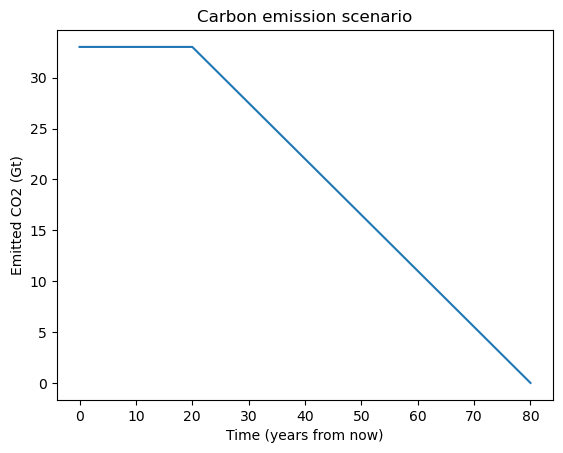

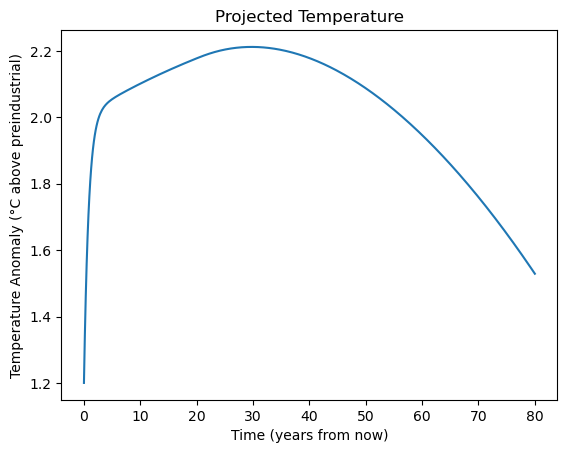

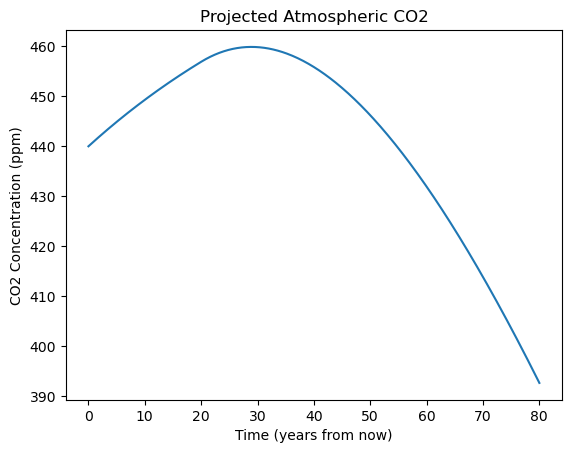

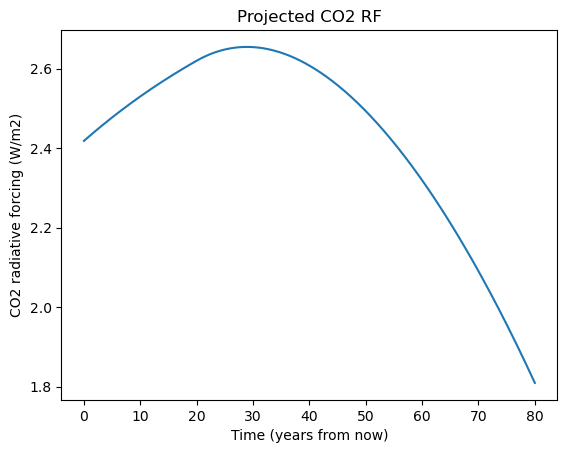

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Parameters ---
C = 1.0
lambda_cl = 1.2
F0 = 0.0
beta = 0.02
C_atm_0 = 280.0    # preindustrial reference for forcing
alpha_CO2 = 5.35

GtC2ppm = 2.13

# Let's start from "present day" (t=0).
T_present = 1.2    # ~1.2 °C above preindustrial
C_present = 440.0  # ~440 ppm

# Emissions scenario from now onward
def emissions_scenario(t):
    # For example: stay at a constant emission of ~9 GtC/yr
    # for 20 years, then linearly drop to 0 by 2100
    if t < 20:
        return 9.0
    elif t < 80:
        # from year 20 to 80, ramp down from 9 to 0
        frac = (80 - t) / 60.0
        return 9.0 * frac
    else:
        return 0.0

def climate_odes(t, y):
    T = y[0]
    C_atm = y[1]

    # Radiative forcing from CO2 (relative to 280 ppm)
    forcing_CO2 = alpha_CO2 * np.log(C_atm / C_atm_0)
    F_in = F0 + forcing_CO2

    dTdt = (F_in - lambda_cl * T) / C
    
    E = emissions_scenario(t)/GtC2ppm 
    uptake = beta * (C_atm - C_atm_0)
    dCdt = E - uptake
    
    return [dTdt, dCdt]

# Solve for 80 years from now
t_span = (0, 80)
y0 = [T_present, C_present]

sol = solve_ivp(
    climate_odes, t_span, y0,
    t_eval=np.linspace(0, 80, 501),
    rtol=1e-6, atol=1e-8
)

t = sol.t
T_sol = sol.y[0]
C_sol = sol.y[1]

# Plot
CtoCO2 = 3.67
plt.figure()
plt.plot(t, [CtoCO2*emissions_scenario(time) for time in t])
plt.xlabel('Time (years from now)')
plt.ylabel('Emitted CO2 (Gt)')
plt.title('Carbon emission scenario')

plt.figure()
plt.plot(t, T_sol)
plt.xlabel('Time (years from now)')
plt.ylabel('Temperature Anomaly (°C above preindustrial)')
plt.title('Projected Temperature')

plt.figure()
plt.plot(t, C_sol)
plt.xlabel('Time (years from now)')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('Projected Atmospheric CO2')

forcing_CO2_sol = alpha_CO2 * np.log(C_sol / C_atm_0)
plt.figure()
plt.plot(t, forcing_CO2_sol)
plt.xlabel('Time (years from now)')
plt.ylabel('CO2 radiative forcing (W/m2)')
plt.title('Projected CO2 RF')

plt.show()


## Theoretical Description of a slightly more complex Model

This code implements a **zero-dimensional climate model** that explicitly tracks both **planetary energy balance** and **atmospheric carbon** (in gigatons of carbon, GtC). The model uses:

1. **Blackbody radiation** for incoming and outgoing fluxes.
2. **Greenhouse forcing** that depends logarithmically on atmospheric carbon.
3. A **one-box carbon cycle** where anthropogenic emissions increase atmospheric carbon, and a linear uptake removes it.

---

### 1. Energy-Balance Equation

We let the planet’s **effective radiating temperature** be \( T(t) \) in kelvins (K). The net energy flux into the planet is:

- Incoming shortwave flux:  
  $$
    \frac{S (1 - \alpha)}{4},
  $$  
  where \( S \) is the solar constant, $ \alpha $ is the planetary albedo, and the factor of 1/4 accounts for geometry and day/night averaging.

- Greenhouse forcing from atmospheric carbon:  
  $$
    F_{\text{GHG}}(t) \;=\; 5.35 \,\ln \!\Bigl(\tfrac{C_{\mathrm{atm}}(t)}{C_{\mathrm{atm},0}}\Bigr),
  $$  
  where $ C_{\mathrm{atm}}(t) $ is the current atmospheric carbon (GtC) and $ C_{\mathrm{atm},0} \approx 596 \,\text{GtC} $ is the preindustrial reference (corresponding to about 280 ppm).

- Outgoing longwave (infrared) flux:  
  $$
    \sigma \,T^4,
  $$  
  where $ \sigma $ is the Stefan–Boltzmann constant.

We also have an **effective heat capacity** \( C \) (in units that allow \( C \, dT/dt \) to represent W m $^{-2}$). Putting this together:

$$
C \,\frac{dT}{dt}
\;=\;
\underbrace{\frac{S (1 - \alpha)}{4}}_{\text{solar input}}
\;+\;
\underbrace{5.35\,\ln\!\Bigl(\tfrac{C_{\mathrm{atm}}(t)}{C_{\mathrm{atm},0}}\Bigr)}_{\text{CO$_2$ forcing}}
\;-\;
\underbrace{\sigma\,T^4}_{\text{IR out}}.
$$

---

### 2. Carbon-Cycle Equation

Let $ C_{\mathrm{atm}}(t) $ be the **mass of carbon** in the atmosphere (in GtC). We include:

- **Emissions** $ E(t) $ in GtC/yr, which we define as a piecewise function of time.  
- A **linear uptake** that removes carbon at a rate proportional to the excess $ C_{\mathrm{atm}}(t) - C_{\mathrm{atm},0} $ above preindustrial:

$$
\beta \,\bigl(C_{\mathrm{atm}}(t) - C_{\mathrm{atm},0}\bigr),
$$
where $ \beta $ is in yr $^{-1}$.

Hence, the carbon cycle ODE is:

$$
\frac{dC_{\mathrm{atm}}}{dt}
\;=\;
E(t)
\;-\;
\beta \,\bigl(C_{\mathrm{atm}} - C_{\mathrm{atm},0}\bigr).
$$

---

### 3. ODE System

Overall, we solve this **two‐equation system**:

$$
\begin{aligned}
& C \,\frac{dT}{dt}
\;=\;
\frac{S (1-\alpha)}{4}
\;+\;
5.35 \,\ln\!\Bigl(\tfrac{C_{\mathrm{atm}}}{C_{\mathrm{atm},0}}\Bigr)
\;-\;
\sigma \,T^4,
\\[6pt]
& \frac{dC_{\mathrm{atm}}}{dt}
\;=\;
E(t)
\;-\;
\beta \,\bigl(C_{\mathrm{atm}} - C_{\mathrm{atm},0}\bigr).
\end{aligned}
$$

with initial conditions near preindustrial equilibrium:
$$
T(0) \approx 254.6 \,\mathrm{K}, 
\quad
C_{\mathrm{atm}}(0) = 596\,\mathrm{GtC}.
$$

Note that Temperature refers to the upper troposphere temperature.

---

### 4. Emissions Scenario

The code defines a function `$emissions_scenario(t)$` that:

- Ramps from 0 to 20 GtC/yr over 50 years,
- Holds at 20 GtC/yr until 100 years,
- Then ramps down to 3 GtC/yr by 150 years,
- Remains at 3 GtC/yr thereafter.

This drives the rise in atmospheric carbon $ C_{\mathrm{atm}}(t) $.

---

### 5. Numerical Integration and Results

We use `scipy.integrate.solve_ivp` to integrate from 0 to 200 years. The solution gives:

- **Temperature** $ T(t) $, in K,
- **Atmospheric carbon** $ C_{\mathrm{atm}}(t) $, in GtC,
- Optionally convert $ C_{\mathrm{atm}} $ to ppm using $1\,\text{ppm} \approx 2.13\,\text{GtC}$.

Plotting these shows how **anthropogenic emissions** cause **$CO_2$** to rise, which **increases radiative forcing** and thus **warms** the planet in this simplified framework.


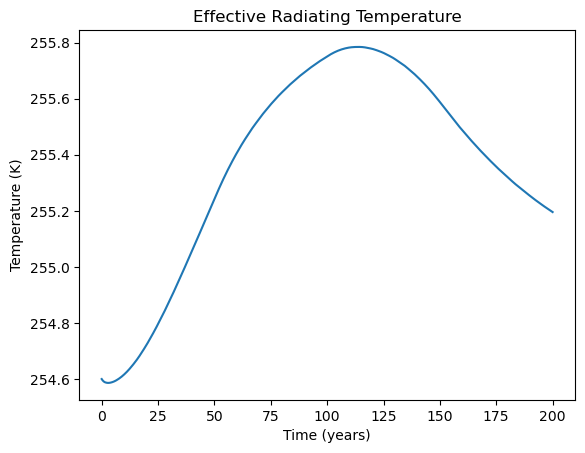

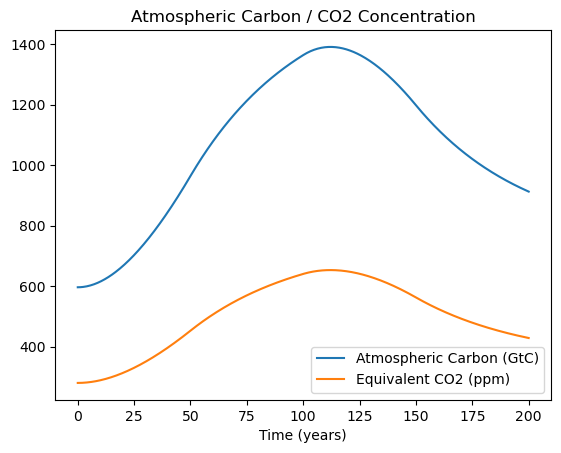

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -----------------------
# 1. Model Parameters
# -----------------------
S = 1361.0       # Solar constant, W/m^2
alpha = 0.3      # Planetary albedo (dimensionless)
sigma = 5.67e-8  # Stefan-Boltzmann constant, W/m^2/K^4

C = 5.0          # Effective heat capacity, (W m^-2 K^-1) * year
                 # (You can adjust this to tune the speed of T response)
C_atm_0 = 596.0  # Preindustrial atmospheric carbon mass, GtC (280 ppm ~ 596 GtC)
beta = 0.02      # Uptake rate, 1/year

# Radiative forcing factor for CO2: 5.35 W/m^2 per ln(C/CO2_ref)
RF_CO2_coef = 5.35

# We'll assume t in years, T in K, C_atm in GtC.


# -----------------------
# 2. Emissions Scenario
# -----------------------
# Let's define a simple piecewise function for E(t) in GtC/yr.
# Example: ramp from 0 at t=0 to 10 GtC/yr by t=50, hold ~10 GtC/yr to t=100,
# then ramp down to 3 GtC/yr by t=150, and stay at 3 afterwards.
def emissions_scenario(t):
    if t < 50:
        # ramp 0 -> 10 over 50 years
        return 20.0 * (t / 50.0)
    elif t < 100:
        return 20.0
    elif t < 150:
        # ramp 10 -> 3 from t=100 to t=150
        fraction = (t - 100.0) / 50.0
        return 20.0 - 17.0 * fraction
    else:
        return 3.0

# -----------------------
# 3. ODE System
# -----------------------
def climate_odes(t, y):
    """
    y[0] = T(t)       -> effective radiating temperature (K)
    y[1] = C_atm(t)   -> atmospheric carbon mass (GtC)
    """
    T = y[0]
    C_atm = y[1]
    
    # 3a) Radiative forcing from CO2
    # Avoid log(0)
    if C_atm < 1e-6:
        C_atm = 1e-6
    F_co2 = RF_CO2_coef * np.log(C_atm / C_atm_0)
    
    # 3b) Net energy flux into the climate (W/m^2)
    #  - solar in: S*(1 - alpha)/4
    #  - IR out: sigma * T^4
    #  - plus greenhouse forcing: F_co2
    F_in = (S * (1 - alpha) / 4.0) + F_co2
    F_out = sigma * T**4
    
    # dT/dt
    dTdt = (F_in - F_out) / C
    
    # 3c) Carbon cycle
    E = emissions_scenario(t)  # GtC/yr
    uptake = beta * (C_atm - C_atm_0)
    dMdt = E - uptake
    
    return [dTdt, dMdt]

# -----------------------
# 4. Solve the ODEs
# -----------------------
# Time span (years)
t_start = 0.0
t_end = 200.0

# We'll start at preindustrial equilibrium:
# At equilibrium, solar_in = sigma T^4 => T ~ 255 K
# C_atm = C_atm_0 = 596 GtC
T_init = 254.6
C_atm_init = C_atm_0

y0 = [T_init, C_atm_init]

t_eval = np.linspace(t_start, t_end, 501)

solution = solve_ivp(
    fun=climate_odes,
    t_span=(t_start, t_end),
    y0=y0,
    t_eval=t_eval,
    rtol=1e-6, atol=1e-8
)

time = solution.t
T_sol = solution.y[0]
C_sol = solution.y[1]

# -----------------------
# 5. Convert C_sol to ppm (if desired)
# -----------------------
# 1 ppm = 2.13 GtC => CO2_ppm(t) = C_sol(t) / 2.13
co2_ppm = C_sol / 2.13


# -----------------------
# 6. Plot Results
# -----------------------
plt.figure()
plt.plot(time, T_sol)
plt.xlabel('Time (years)')
plt.ylabel('Temperature (K)')
plt.title('Effective Radiating Temperature')

plt.figure()
plt.plot(time, C_sol, label='Atmospheric Carbon (GtC)')
plt.plot(time, co2_ppm, label='Equivalent CO2 (ppm)')
plt.xlabel('Time (years)')
plt.legend()
plt.title('Atmospheric Carbon / CO2 Concentration')

plt.show()
